In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import os

# ==================== CONFIG ====================
DATA_DIR = 'C:/Users/pc/Desktop/Attention/dataset_split'
BATCH_SIZE = 32
IMG_SIZE = 96
EPOCHS = 20
LEARNING_RATE = 1e-4
MODEL_PATH = 'C:/Users/pc/Desktop/Attention/densenet169_2class.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==================== CUSTOM DENSENET169 ====================
class DenseNet169_Base(nn.Module):
    def __init__(self, num_classes=2):
        super(DenseNet169_Base, self).__init__()
        self.backbone = models.densenet169(pretrained=True)
        num_ftrs = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.backbone(x)

# ==================== DATASET ====================
class BacteriaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        label_map = {'negative': 0, 'positive': 1}
        for label_name, label_id in label_map.items():
            folder = os.path.join(root_dir, label_name)
            if not os.path.exists(folder):
                continue
            for img_name in os.listdir(folder):
                self.samples.append((os.path.join(folder, img_name), label_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# ==================== TRANSFORMS ====================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ==================== DATA LOADERS ====================
train_data = BacteriaDataset(os.path.join(DATA_DIR, 'train'), transform=train_transform)
val_data = BacteriaDataset(os.path.join(DATA_DIR, 'val'), transform=val_test_transform)
test_data = BacteriaDataset(os.path.join(DATA_DIR, 'test'), transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# ==================== CLASS WEIGHTS ====================
label_counts = [0, 0]
for _, label in train_data:
    label_counts[label] += 1

total_samples = sum(label_counts)
class_weights = torch.tensor([
    total_samples / (2 * count) if count > 0 else 0.0 for count in label_counts
], dtype=torch.float).to(device)

# ==================== TRAINING FUNCTION ====================
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct += (val_predicted == val_labels).sum().item()
                val_total += val_labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    torch.save(model.state_dict(), MODEL_PATH)
    print("✅ Final model saved successfully!")

# ==================== RUN TRAINING ====================
model = DenseNet169_Base(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, EPOCHS)


E:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
E:\anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 | Train Loss: 0.2462, Train Acc: 90.05% | Val Loss: 0.0301, Val Acc: 100.00%
Epoch 2/20 | Train Loss: 0.0195, Train Acc: 99.52% | Val Loss: 0.0102, Val Acc: 100.00%
Epoch 3/20 | Train Loss: 0.0079, Train Acc: 99.84% | Val Loss: 0.0038, Val Acc: 100.00%
Epoch 4/20 | Train Loss: 0.0072, Train Acc: 99.68% | Val Loss: 0.0035, Val Acc: 100.00%
Epoch 5/20 | Train Loss: 0.0038, Train Acc: 100.00% | Val Loss: 0.0030, Val Acc: 100.00%
Epoch 6/20 | Train Loss: 0.0019, Train Acc: 100.00% | Val Loss: 0.0032, Val Acc: 100.00%
Epoch 7/20 | Train Loss: 0.0066, Train Acc: 99.84% | Val Loss: 0.0033, Val Acc: 100.00%
Epoch 8/20 | Train Loss: 0.0033, Train Acc: 100.00% | Val Loss: 0.0009, Val Acc: 100.00%
Epoch 9/20 | Train Loss: 0.0014, Train Acc: 100.00% | Val Loss: 0.0009, Val Acc: 100.00%
Epoch 10/20 | Train Loss: 0.0011, Train Acc: 100.00% | Val Loss: 0.0008, Val Acc: 100.00%
Epoch 11/20 | Train Loss: 0.0007, Train Acc: 100.00% | Val Loss: 0.0006, Val Acc: 100.00%
Epoch 12/20 | Train Loss

E:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Classification Report:

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       104
    positive       1.00      1.00      1.00       189

    accuracy                           1.00       293
   macro avg       1.00      1.00      1.00       293
weighted avg       1.00      1.00      1.00       293

🧮 Confusion Matrix:
[[104   0]
 [  0 189]]


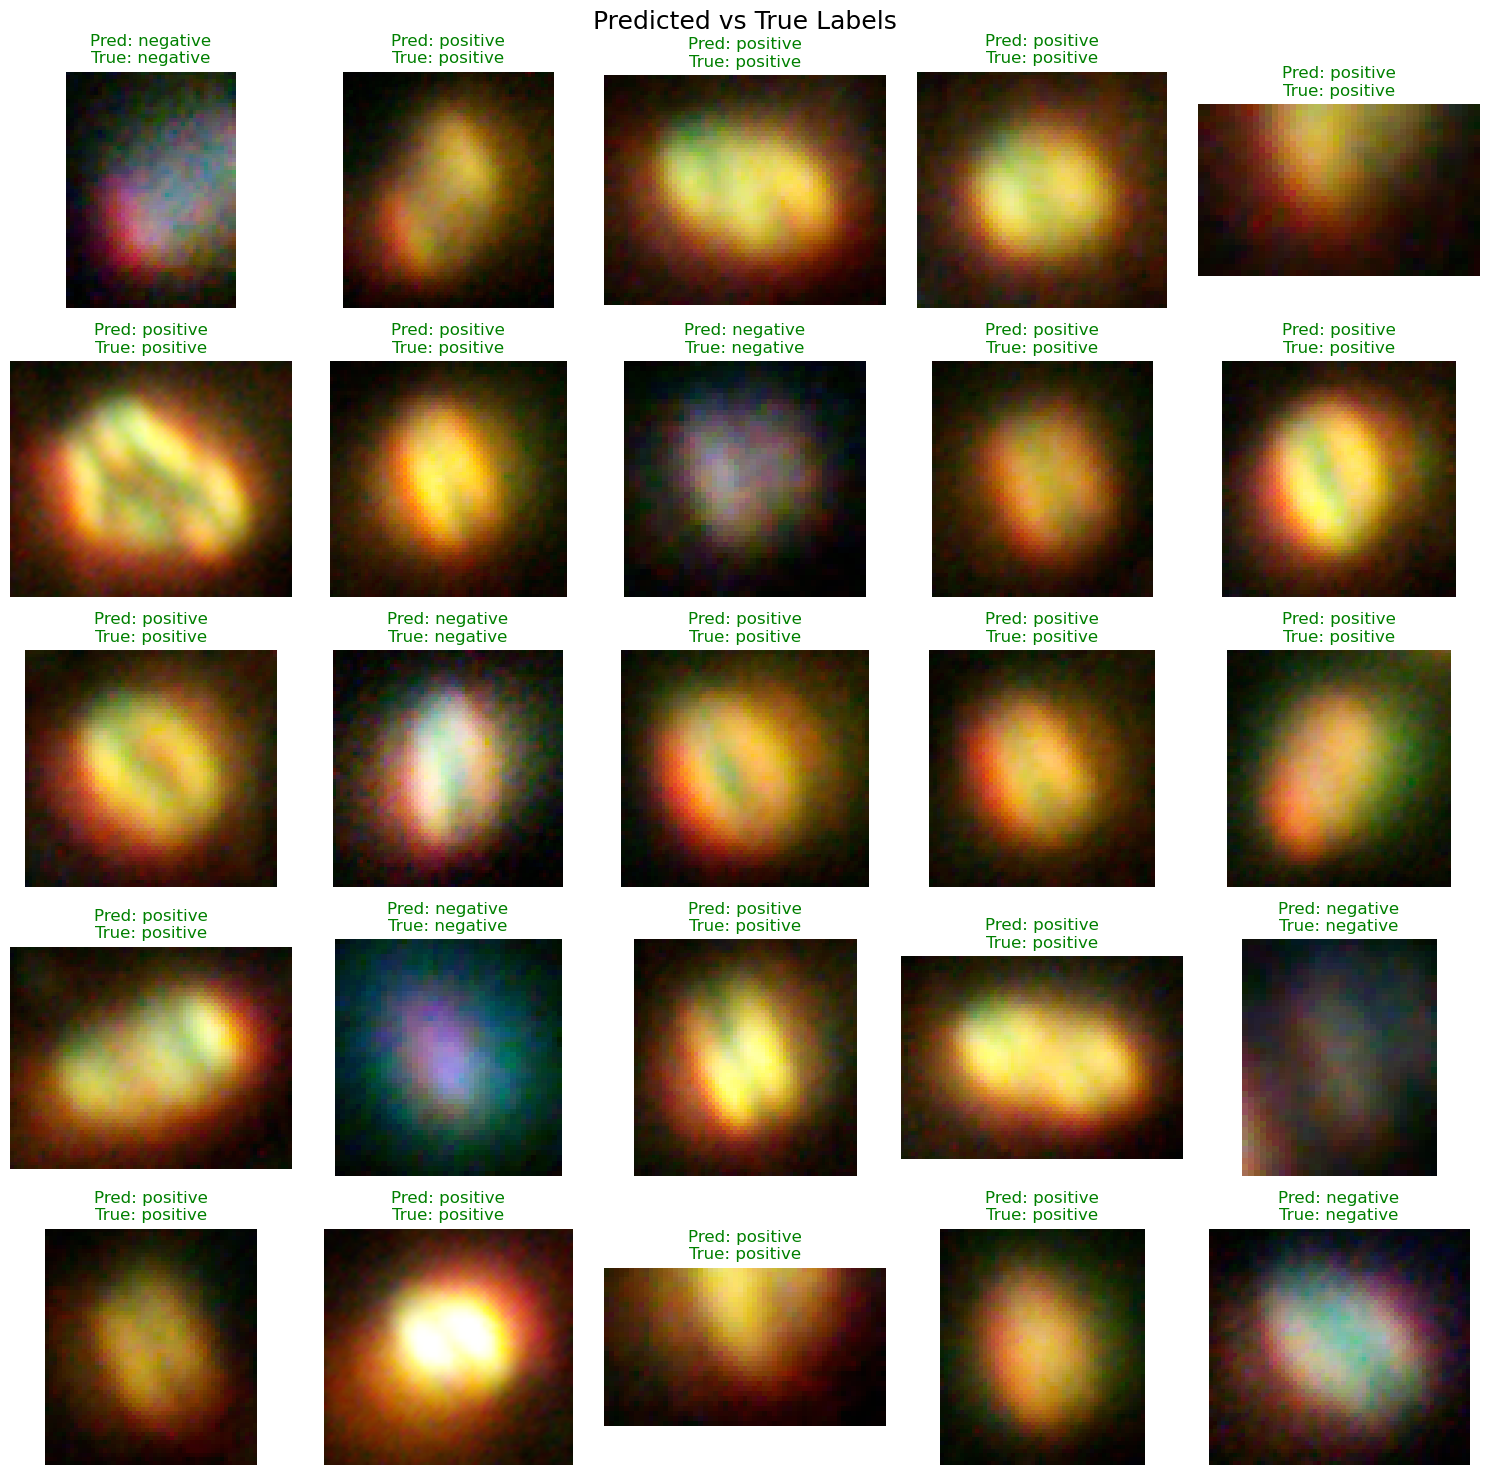

In [3]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import random
from PIL import Image
import os

# ======== CONFIG ========
MODEL_PATH = 'C:/Users/pc/Desktop/Attention/densenet169_2class.pth'
TEST_DIR = 'C:/Users/pc/Desktop/Attention/dataset_split/test'
IMG_SIZE = 96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======== MODEL ========
from torchvision import models
import torch.nn as nn

class DenseNet169_Binary(nn.Module):
    def __init__(self):
        super(DenseNet169_Binary, self).__init__()
        self.backbone = models.densenet169(pretrained=False)
        num_ftrs = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        return self.backbone(x)

model = DenseNet169_Binary().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ======== TRANSFORM ========
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# ======== LOAD TEST DATA ========
label_map = {'negative': 0, 'positive': 1}
reverse_label_map = {v: k for k, v in label_map.items()}
samples = []
for label_name in label_map:
    folder = os.path.join(TEST_DIR, label_name)
    for img_name in os.listdir(folder):
        path = os.path.join(folder, img_name)
        samples.append((path, label_map[label_name]))

# ======== EVALUATE ========
y_true = []
y_pred = []

with torch.no_grad():
    for path, label in samples:
        image = Image.open(path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        y_true.append(label)
        y_pred.append(predicted.item())

print("✅ Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_map.keys()))

print("🧮 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ======== VISUALIZE 25 RANDOM TEST IMAGES ========
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle("Predicted vs True Labels", fontsize=18)

chosen_samples = random.sample(samples, 25)

for idx, (path, true_label) in enumerate(chosen_samples):
    image = Image.open(path).convert("RGB")
    display_img = image.copy()  # untransformed
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    pred_label = predicted.item()
    label_text = f"Pred: {reverse_label_map[pred_label]}\nTrue: {reverse_label_map[true_label]}"
    axs[idx // 5, idx % 5].imshow(display_img)
    axs[idx // 5, idx % 5].set_title(label_text, color="green" if pred_label == true_label else "red")
    axs[idx // 5, idx % 5].axis("off")

plt.tight_layout()
plt.show()


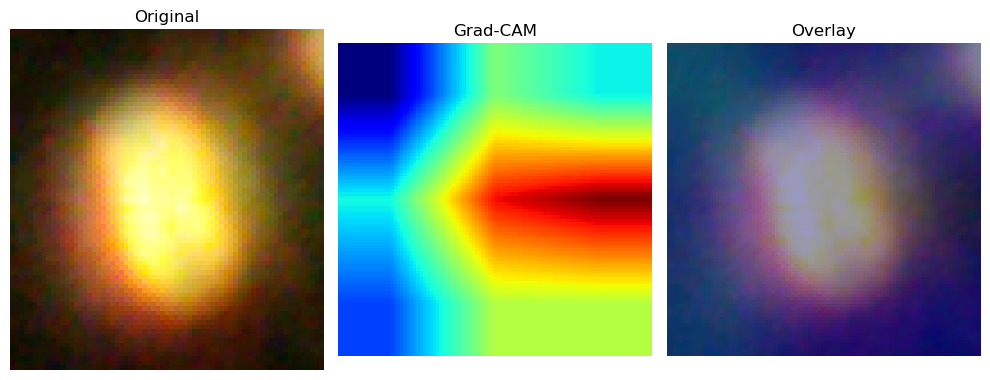

In [71]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# ========= CONFIG =========
MODEL_PATH = 'C:/Users/pc/Desktop/Attention/densenet169_2class.pth'
IMG_SIZE = 96
NUM_CLASSES = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========= MODEL LOADING =========
class DenseNet169Classifier(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(DenseNet169Classifier, self).__init__()
        self.backbone = models.densenet169(pretrained=True)
        num_ftrs = self.backbone.classifier.in_features
        self.backbone.classifier = torch.nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.backbone(x)

model = DenseNet169Classifier(num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ========= TRANSFORMS =========
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# ========= GRAD-CAM UTILS =========
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output)

        self.model.zero_grad()
        output[0, class_idx].backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
        return heatmap

# ========= VISUALIZATION =========
def visualize_gradcam(img_path):
    # Load image
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Initialize Grad-CAM
    target_layer = model.backbone.features[-1]  # Final feature layer in DenseNet169
    grad_cam = GradCAM(model, target_layer)
    heatmap = grad_cam.generate_heatmap(input_tensor)

    # Convert image to OpenCV format
    img_cv = np.array(image.resize((IMG_SIZE, IMG_SIZE)))
    heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_colored, 0.4, 0)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM")
    plt.imshow(heatmap_resized, cmap='jet')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(superimposed_img)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# ========= USAGE EXAMPLE =========
# Replace with a path to a test image
test_image_path = 'C:/Users/pc/Desktop/Attention/dataset_split/test/positive/vpo+0029_crop_0131.tif'
visualize_gradcam(test_image_path)


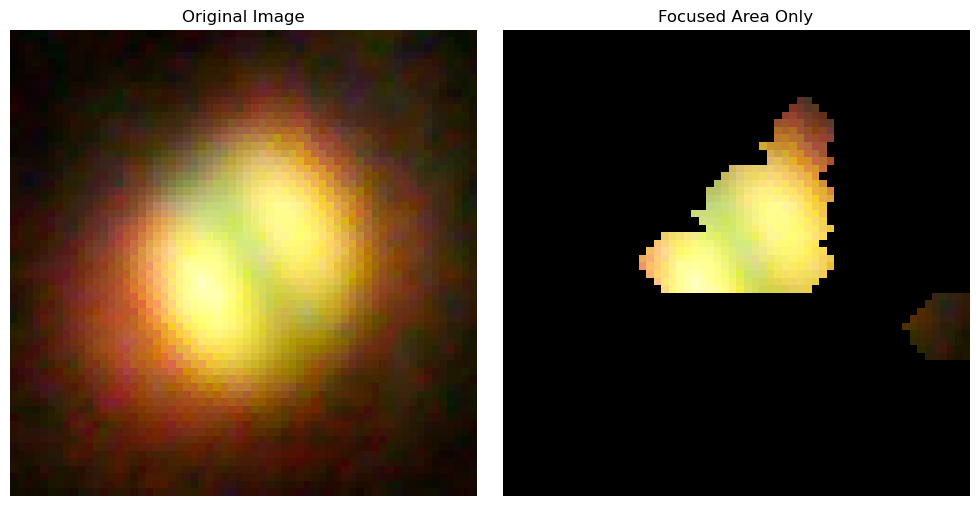

In [35]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from torchvision import models
import os

# ========= Paths =========
MODEL_PATH = r"C:/Users/pc/Desktop/Attention/densenet169_2class.pth"
IMAGE_PATH = r"C:/Users/pc/Desktop/Attention/dataset_split/test/positive/vpo+0028_crop_0049.tif"  # change to your test image path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========= Load DenseNet169 Model =========
class DenseNet169_Custom(nn.Module):
    def __init__(self, num_classes=2):
        super(DenseNet169_Custom, self).__init__()
        self.backbone = models.densenet169(pretrained=False)
        num_ftrs = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.backbone(x)

model = DenseNet169_Custom().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ========= GradCAM Hook =========
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax().item()

        self.model.zero_grad()
        output[0, class_idx].backward()

        gradients = self.gradients[0]
        activations = self.activations[0]

        weights = gradients.mean(dim=[1, 2], keepdim=True)
        cam = torch.relu((weights * activations).sum(0))

        cam -= cam.min()
        cam /= cam.max()
        return cam.cpu().numpy()

# ========= Image Preprocessing =========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0).to(device)

# ========= Run & Mask Image =========
def apply_focus_mask(img_path):
    original_img, input_tensor = load_image(img_path)

    target_layer = model.backbone.features.denseblock4.denselayer32.conv2
    gradcam = GradCAM(model, target_layer)
    cam = gradcam.generate(input_tensor)

    # Threshold CAM to binary mask
    threshold = 0.6
    mask = (cam > threshold).astype(np.uint8)

    # Resize mask to match original image
    mask = cv2.resize(mask, original_img.size)

    # Convert original image to numpy
    img_np = np.array(original_img)

    # Apply mask (broadcast across 3 channels)
    focus = img_np * mask[..., np.newaxis]

    # Show result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img_np)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Focused Area Only")
    plt.imshow(focus)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# ========= RUN =========
apply_focus_mask(IMAGE_PATH)


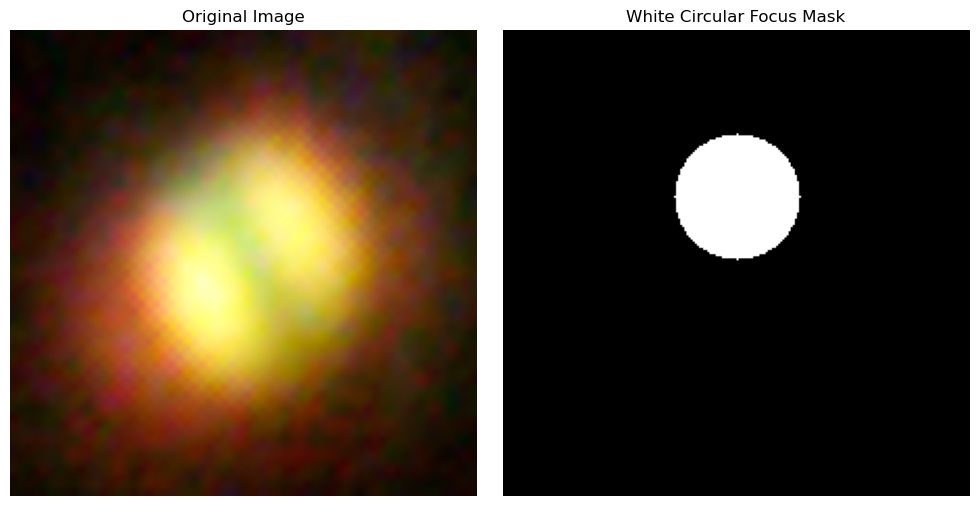

In [57]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from torchvision import models

# ====== Paths ======
MODEL_PATH = r"C:/Users/pc/Desktop/Attention/densenet169_2class.pth"
IMAGE_PATH = r"C:/Users/pc/Desktop/Attention/dataset_split/test/positive/vpo+0028_crop_0049.tif"  # ← your test image here

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== DenseNet169 Model ======
class DenseNet169_Custom(nn.Module):
    def __init__(self, num_classes=2):
        super(DenseNet169_Custom, self).__init__()
        self.backbone = models.densenet169(pretrained=False)
        num_ftrs = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.backbone(x)

model = DenseNet169_Custom().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ====== Grad-CAM ======
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax().item()

        self.model.zero_grad()
        output[0, class_idx].backward()

        gradients = self.gradients[0]
        activations = self.activations[0]

        weights = gradients.mean(dim=[1, 2], keepdim=True)
        cam = torch.relu((weights * activations).sum(0))

        cam -= cam.min()
        cam /= cam.max()
        return cam.cpu().numpy()

# ====== Image Loading ======
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transformed = transform(image).unsqueeze(0).to(device)
    return image.resize((224, 224)), transformed

# ====== Generate Focus Mask & Show ======
def show_focus_mask(image_path, radius=30):
    original_img, input_tensor = load_image(image_path)

    # Grad-CAM Setup
    target_layer = model.backbone.features.denseblock4.denselayer32.conv2
    gradcam = GradCAM(model, target_layer)
    cam = gradcam.generate(input_tensor)
    cam_resized = cv2.resize(cam, (224, 224))

    # Max location = center of focus
    max_loc = np.unravel_index(np.argmax(cam_resized), cam_resized.shape)
    center_y, center_x = max_loc

    # Create circular mask
    mask = np.zeros((224, 224), dtype=np.uint8)
    cv2.circle(mask, (center_x, center_y), radius, 255, thickness=-1)

    # Show original + mask side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_img)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("White Circular Focus Mask")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

# ====== RUN ======
show_focus_mask(IMAGE_PATH)


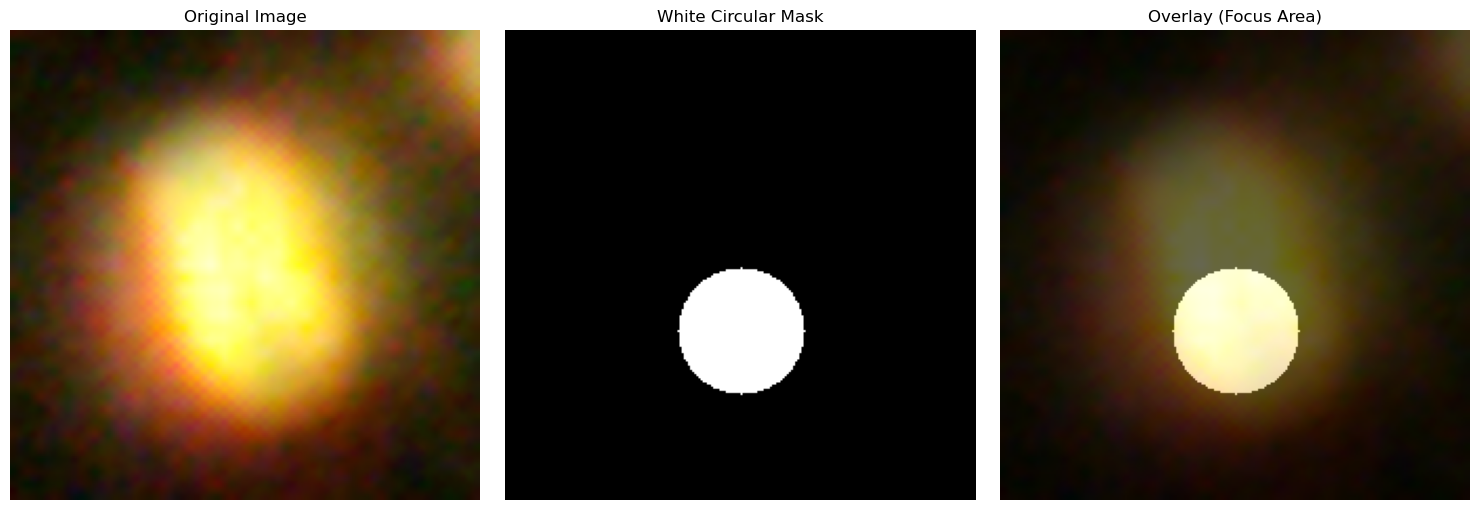

In [65]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from torchvision import models

# ====== Paths ======
MODEL_PATH = r"C:/Users/pc/Desktop/Attention/densenet169_2class.pth"
IMAGE_PATH = r"C:/Users/pc/Desktop/Attention/dataset_split/test/positive/vpo+0029_crop_0131.tif"  # ← your test image here

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== DenseNet169 Model ======
class DenseNet169_Custom(nn.Module):
    def __init__(self, num_classes=2):
        super(DenseNet169_Custom, self).__init__()
        self.backbone = models.densenet169(pretrained=False)
        num_ftrs = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.backbone(x)

model = DenseNet169_Custom().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ====== Grad-CAM ======
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax().item()

        self.model.zero_grad()
        output[0, class_idx].backward()

        gradients = self.gradients[0]
        activations = self.activations[0]

        weights = gradients.mean(dim=[1, 2], keepdim=True)
        cam = torch.relu((weights * activations).sum(0))

        cam -= cam.min()
        cam /= cam.max()
        return cam.cpu().numpy()

# ====== Image Loading ======
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transformed = transform(image).unsqueeze(0).to(device)
    return image.resize((224, 224)), transformed

# ====== Generate Focus Mask, Show Original, Mask & Overlay ======
def show_focus_and_overlay(image_path, radius=30):
    original_img, input_tensor = load_image(image_path)

    # Grad-CAM Setup
    target_layer = model.backbone.features.denseblock4.denselayer32.conv2
    gradcam = GradCAM(model, target_layer)
    cam = gradcam.generate(input_tensor)
    cam_resized = cv2.resize(cam, (224, 224))

    # Max location = center of focus
    max_loc = np.unravel_index(np.argmax(cam_resized), cam_resized.shape)
    center_y, center_x = max_loc

    # Create circular mask
    mask = np.zeros((224, 224), dtype=np.uint8)
    cv2.circle(mask, (center_x, center_y), radius, 255, thickness=-1)

    # Create the overlay image
    original_img_np = np.array(original_img)
    overlay = original_img_np.copy()
    mask_rgb = cv2.merge([mask, mask, mask])  # Convert mask to RGB
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
    alpha = 0.6  # Transparency factor
    overlay = cv2.addWeighted(overlay, 1 - alpha, mask_rgb, alpha, 0)

    # Show original, mask, and overlay side by side
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(original_img)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("White Circular Mask")
    axs[1].axis("off")

    axs[2].imshow(overlay)
    axs[2].set_title("Overlay (Focus Area)")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

# ====== RUN ======
show_focus_and_overlay(IMAGE_PATH)


In [97]:
import os
import pandas as pd

# Set your dataset split directories
train_dir = "C:/Users/pc/Desktop/Attention/dataset_split/train"
val_dir   = "C:/Users/pc/Desktop/Attention/dataset_split/val"
test_dir  = "C:/Users/pc/Desktop/Attention/dataset_split/test"

# Folder names (lowercase)
class_names = ['positive', 'negative']

# Include .tif in the supported extensions
valid_extensions = ('.jpg', '.jpeg', '.png', '.tif', '.tiff')

def count_images_in_class(root_dir):
    data = {}
    for cls in class_names:
        class_path = os.path.join(root_dir, cls)
        print(f"🔍 Checking: {class_path}")  # Optional debug
        if os.path.exists(class_path):
            count = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(valid_extensions)
            ])
            data[cls] = count
        else:
            data[cls] = 0
    return data

# Count per class for each split
train_counts = count_images_in_class(train_dir)
val_counts   = count_images_in_class(val_dir)
test_counts  = count_images_in_class(test_dir)

# Create dataframe for display
summary_df = pd.DataFrame({
    'Class': ['1 (Positive)', '0 (Negative)'],
    'Train': [train_counts['positive'], train_counts['negative']],
    'Validation': [val_counts['positive'], val_counts['negative']],
    'Test': [test_counts['positive'], test_counts['negative']],
})

# Display table
print("\n📊 Dataset Distribution:\n")
print(summary_df.to_string(index=False))


🔍 Checking: C:/Users/pc/Desktop/Attention/dataset_split/train\positive
🔍 Checking: C:/Users/pc/Desktop/Attention/dataset_split/train\negative
🔍 Checking: C:/Users/pc/Desktop/Attention/dataset_split/val\positive
🔍 Checking: C:/Users/pc/Desktop/Attention/dataset_split/val\negative
🔍 Checking: C:/Users/pc/Desktop/Attention/dataset_split/test\positive
🔍 Checking: C:/Users/pc/Desktop/Attention/dataset_split/test\negative

📊 Dataset Distribution:

       Class  Train  Validation  Test
1 (Positive)    311         188   189
0 (Negative)    312         104   104


In [101]:
!pip install torchinfo


In [105]:
import torch
from torchvision.models import densenet169, DenseNet169_Weights
from torchinfo import summary

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the same class as before
class DenseNet169_Base(nn.Module):
    def __init__(self, num_classes=2):
        super(DenseNet169_Base, self).__init__()
        self.backbone = densenet169(weights=DenseNet169_Weights.DEFAULT)
        num_ftrs = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Initialize model and load weights
model = DenseNet169_Base(num_classes=2).to(device)
model.load_state_dict(torch.load('C:/Users/pc/Desktop/Attention/densenet169_2class.pth', map_location=device))
model.eval()

# Print summary
summary(model, input_size=(1, 3, 96, 96))  # 1 is batch size


Layer (type:depth-idx)                        Output Shape              Param #
DenseNet169_Base                              [1, 2]                    --
├─DenseNet: 1-1                               [1, 2]                    --
│    └─Sequential: 2-1                        [1, 1664, 3, 3]           --
│    │    └─Conv2d: 3-1                       [1, 64, 48, 48]           9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 48, 48]           128
│    │    └─ReLU: 3-3                         [1, 64, 48, 48]           --
│    │    └─MaxPool2d: 3-4                    [1, 64, 24, 24]           --
│    │    └─_DenseBlock: 3-5                  [1, 256, 24, 24]          335,040
│    │    └─_Transition: 3-6                  [1, 128, 12, 12]          33,280
│    │    └─_DenseBlock: 3-7                  [1, 512, 12, 12]          919,680
│    │    └─_Transition: 3-8                  [1, 256, 6, 6]            132,096
│    │    └─_DenseBlock: 3-9                  [1, 1280, 6, 6]           

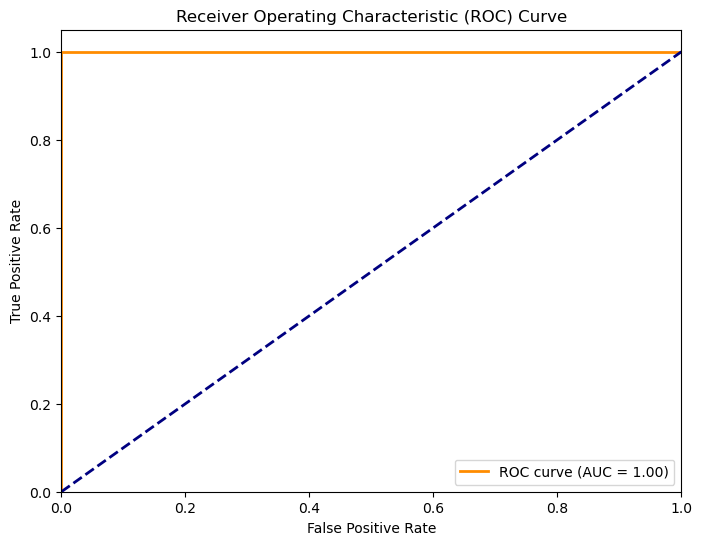

AUC Score: 1.0000


In [107]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import roc_auc_score

# ==================== Custom Dataset for Test Data ====================
# Assuming your Dataset class is already defined as `BacteriaDataset`
test_data = BacteriaDataset(root_dir='C:/Users/pc/Desktop/Attention/dataset_split/test', transform=val_test_transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# ==================== Load the Trained Model ====================
model = DenseNet169_Base(num_classes=2).to(device)
model.load_state_dict(torch.load('C:/Users/pc/Desktop/Attention/densenet169_2class.pth', map_location=device))
model.eval()

# ==================== Get Predictions ====================
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Append the true labels and predicted probabilities
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs[:, 1].cpu().numpy())  # The second column is the positive class probability

# ==================== ROC Curve and AUC ====================
# Convert labels to binary (e.g., [0, 1] for Negative and Positive classes)
y_true = np.array(all_labels)
y_score = np.array(all_preds)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# ==================== Plot ROC Curve ====================
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# ==================== AUC Score ====================
print(f"AUC Score: {roc_auc:.4f}")


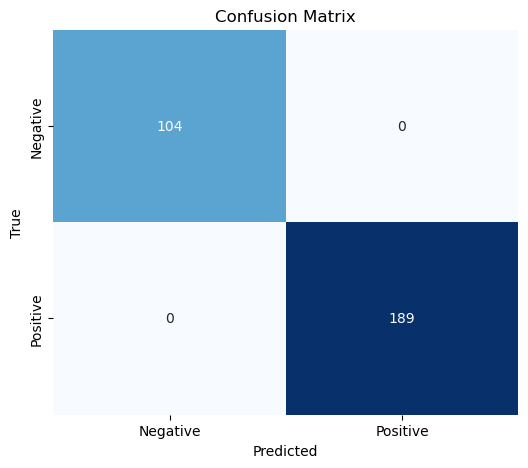

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix values
cm = np.array([[104, 0],
               [0, 189]])

# Labels for the classes
labels = ['Negative', 'Positive']

# Create the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

# Adding labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
